## Introduction

**I. Dataset Information**

- id : Unique Identifier for each Asteroid
- name : Name given by NASA
- est_diameter_min : Minimum Estimated Diameter in Kilometres
- est_diameter_max : Maximum Estimated Diameter in Kilometres
- relative_velocity : Velocity Relative to Earth in Kmph
- miss_distance : Distance in Kilometres missed
- orbiting_body : Planet that the asteroid orbits
- sentry_object : Included in sentry - automated collision monitoring system
- absolute_magnitude : Describes intrinsic luminosity

**Target Label**
- hazardous : Boolean feature that shows whether asteroid is harmful or not

## Import Libraries


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from datetime import datetime as dt
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
from matplotlib import cm

# Data Preprocessing
from sklearn.model_selection import train_test_split
from feature_engine.outliers import OutlierTrimmer, Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder, OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE, SMOTENC

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from mlxtend.plotting import plot_confusion_matrix

# Metric
from sklearn.metrics import classification_report, roc_auc_score, auc, RocCurveDisplay, roc_curve, confusion_matrix

# Deployment
import joblib

from packages.checker import check_unique
from packages.checker import check_missing, check_missing_special
from packages.outlier_handling import check_outlier, check_dist, outlier_summary, trim_cap_outliers

import warnings
warnings.filterwarnings("ignore")

## Data Loading

In [2]:
# Load Data and save it in `df_og` variable
df_train_test = pd.read_csv('data/neo_v2.csv')

# Make copy from the df
df = df_train_test.copy()

**Dataset preview**

In [3]:
# Show the Dataset
pd.set_option('display.max_columns', None)
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [4]:
df.tail()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
90831,3763337,(2016 VX1),0.026580,0.059435,52078.886692,1.230039e+07,Earth,False,25.00,False
90832,3837603,(2019 AD3),0.016771,0.037501,46114.605073,5.432121e+07,Earth,False,26.00,False
90833,54017201,(2020 JP3),0.031956,0.071456,7566.807732,2.840077e+07,Earth,False,24.60,False
90834,54115824,(2021 CN5),0.007321,0.016370,69199.154484,6.869206e+07,Earth,False,27.80,False
90835,54205447,(2021 TW7),0.039862,0.089133,27024.455553,5.977213e+07,Earth,False,24.12,False


In [5]:
# Dataset shape 
df.shape

(90836, 10)

In [6]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [7]:
# Null value summary
df.isnull().sum().sort_values()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [8]:
check_unique(df)

,feats,num_unique,pct_unique
0,id,27423,30.189572
1,name,27423,30.189572
2,est_diameter_min,1638,1.803250
3,est_diameter_max,1638,1.803250
4,relative_velocity,90828,99.991193
5,miss_distance,90536,99.669734
6,orbiting_body,1,0.001101
7,absolute_magnitude,1638,1.803250


### Cardinality of Orbiting Body and Sentry Object

In [9]:
# check the cardinality of each nominal and ordinal features
print("Nominal and ordinal features cardinality:")
for col in df.columns:
    if df[col].nunique() < 20:
        print(col, ':', df[col].nunique(), 'unique values \n', np.sort(df[col].unique()))
        print('-' * 100)

Nominal and ordinal features cardinality:
orbiting_body : 1 unique values 
 ['Earth']
----------------------------------------------------------------------------------------------------
sentry_object : 1 unique values 
 [False]
----------------------------------------------------------------------------------------------------
hazardous : 2 unique values 
 [False  True]
----------------------------------------------------------------------------------------------------


Since our research is on nearest space objects around earth, it's normal for the orbiting body to be the planet earth itself.

All the objects are not sentry objects.

Since these two features only have one unique value, we can drop them.

In [10]:
# drop the columns with only one unique values
df = df.drop(columns=['orbiting_body', 'sentry_object'])

In [11]:
# dropping 'id' column
df = df.drop(columns=['id'])

In [12]:
# check duplicate values in dataset
df[df.duplicated(subset=['name'])].name.value_counts()

469219 Kamo`oalewa (2016 HO3)    42
277810 (2006 FV35)               42
(2016 CA138)                     39
138175 (2000 EE104)              38
(2019 XS)                        37
                                 ..
(2019 HL4)                        1
(2010 UE51)                       1
(2007 VC138)                      1
(2014 KE39)                       1
(2018 BN3)                        1
Name: name, Length: 15902, dtype: int64

In [13]:
df[df.name == '469219 Kamo`oalewa (2016 HO3)'].head(10)

,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
912,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,15334.830488,2.105350e+07,24.33,False
2169,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,15860.941084,2.297678e+07,24.33,False
3972,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,15382.529101,2.032125e+07,24.33,False
5128,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,15285.830876,2.345715e+07,24.33,False
6988,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,15464.296154,1.954735e+07,24.33,False
8091,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,14629.980565,2.383909e+07,24.33,False
10081,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,15445.978808,1.880784e+07,24.33,False
11183,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,13963.527790,2.409758e+07,24.33,False
13252,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,15495.759121,1.812412e+07,24.33,False
14401,469219 Kamo`oalewa (2016 HO3),0.036187,0.080917,13260.624583,2.424962e+07,24.33,False


In [14]:
# Dataset Check
df.describe(percentiles=[0.5]).round().T

,count,mean,std,min,50%,max
est_diameter_min,90836.0,0.0,0.0,0.0,0.0,38.0
est_diameter_max,90836.0,0.0,1.0,0.0,0.0,85.0
relative_velocity,90836.0,48067.0,25293.0,203.0,44190.0,236990.0
miss_distance,90836.0,37066546.0,22352041.0,6746.0,37846579.0,74798651.0
absolute_magnitude,90836.0,24.0,3.0,9.0,24.0,33.0


In [15]:
# Dataset Check
df.describe(include=object).T

,count,unique,top,freq
name,90836,27423,469219 Kamo`oalewa (2016 HO3),43


Insight of Dataset Preview process:

Based on above process, i get these following information:
- The dataset consist of 90836 rows of entries and 10 columns.
- The dataset are 5 features float type, 2 features of object type, 1 feature of integer type and 2 features of boolean type.
- There are no any missing value on this dataset.
- There are some duplicates value but we gonna explore them more later.

---

## Exploratory Data Analysis

**Preset**

In [16]:
# Create preset palette
palette = {False : '#014F9D', True : '#DB0707'}

**Preliminary Check**

In [17]:
# Preliminary Check
# Variable : est_diameter_min
# Description : Minimum Estimated Diameter in Kilometres

var = 'est_diameter_min'

print('variable:', var)
print('null value count: ', df[var].isnull().sum())
print()
print('Descriptive stats:')
print(df[var].describe())

variable: est_diameter_min
null value count:  0

Descriptive stats:
count    90836.000000
mean         0.127432
std          0.298511
min          0.000609
25%          0.019256
50%          0.048368
75%          0.143402
max         37.892650
Name: est_diameter_min, dtype: float64


In [18]:
# Preliminary Check
# Variable : est_diameter_max
# Description : Maximum Estimated Diameter in Kilometres

var = 'est_diameter_max'

print('variable:', var)
print('null value count: ', df[var].isnull().sum())
print()
print('Descriptive stats:')
print(df[var].describe())

variable: est_diameter_max
null value count:  0

Descriptive stats:
count    90836.000000
mean         0.284947
std          0.667491
min          0.001362
25%          0.043057
50%          0.108153
75%          0.320656
max         84.730541
Name: est_diameter_max, dtype: float64


In this two features we can see has the same definition, we need to check it later, what we are going to do to this features.

In [19]:
# Preliminary Check
# Variable : relative_velocity
# Description : Velocity Relative to Earth in Kmph

var = 'relative_velocity'

print('variable:', var)
print('null value count: ', df[var].isnull().sum())
print()
print('Descriptive stats:')
print(df[var].describe())

variable: relative_velocity
null value count:  0

Descriptive stats:
count     90836.000000
mean      48066.918918
std       25293.296961
min         203.346433
25%       28619.020645
50%       44190.117890
75%       62923.604633
max      236990.128088
Name: relative_velocity, dtype: float64


Looks like relative_velocity is already match with the columns description, so we can use it.

In [20]:
# Preliminary Check
# Variable : miss_distance
# Description : Distance in Kilometres missed

var = 'miss_distance'

print('variable:', var)
print('null value count: ', df[var].isnull().sum())
print()
print('Descriptive stats:')
print(df[var].describe())

variable: miss_distance
null value count:  0

Descriptive stats:
count    9.083600e+04
mean     3.706655e+07
std      2.235204e+07
min      6.745533e+03
25%      1.721082e+07
50%      3.784658e+07
75%      5.654900e+07
max      7.479865e+07
Name: miss_distance, dtype: float64


Looks like relative_velocity is already match with the columns description, so we can use it.

In [21]:
# Preliminary Check
# Variable : absolute_magnitude
# Description : Describes intrinsic luminosity

var = 'absolute_magnitude'

print('variable:', var)
print('null value count: ', df[var].isnull().sum())
print()
print('Descriptive stats:')
print(df[var].describe())

variable: absolute_magnitude
null value count:  0

Descriptive stats:
count    90836.000000
mean        23.527103
std          2.894086
min          9.230000
25%         21.340000
50%         23.700000
75%         25.700000
max         33.200000
Name: absolute_magnitude, dtype: float64


In [22]:
# Preliminary Check
# Variable : name
# Description : Name by NASA

var = 'name'

print('variable:', var)
print('null value count: ', df[var].isnull().sum())
print()
print('Unique Value Count:', df[var].nunique())
print(df[var].unique())
print(df[var].dtype)


variable: name
null value count:  0

Unique Value Count: 27423
['162635 (2000 SS164)' '277475 (2005 WK4)' '512244 (2015 YE18)' ...
 '(2021 WR3)' '(2015 VK142)' '(1999 LV7)']
object


In [24]:
# # Preliminary Check
# # Variable : orbiting_body
# # Description : Name by NASA

# var = 'orbiting_body'

# print('variable:', var)
# print('null value count: ', df[var].isnull().sum())
# print()
# print('Unique Value Count:', df[var].nunique())
# print(df[var].unique())
# print(df[var].dtype)

In [25]:
# # Preliminary Check
# # Variable : sentry_object
# # Description : Name by NASA

# var = 'sentry_object'

# print('variable:', var)
# print('null value count: ', df[var].isnull().sum())
# print()
# print('Unique Value Count:', df[var].nunique())
# print(df[var].unique())
# print(df[var].dtype)

**Univariate Analysis**

In this sub-process, we will try to explore boolean features and see the distribution of our target value is "hazardous", let's get to know about it more deeply.

In [26]:
# Number of unique value
print(df['hazardous'].value_counts())
print()
print(df['hazardous'].value_counts(normalize=True)*100)

False    81996
True      8840
Name: hazardous, dtype: int64

False    90.268176
True      9.731824
Name: hazardous, dtype: float64


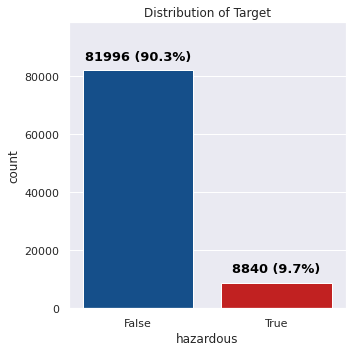

In [27]:
# Distribution Check

plt.figure(figsize=(5, 5))
ax = sns.countplot(df['hazardous'],  palette=palette )
    
ax.set_title("Distribution of Target")
ax.set_ylim(0, df['hazardous'].value_counts().max()*1.2)
# Annot bar
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f') + " (" + format(p.get_height()*100/len(df), '.1f') + "%)",
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center',
        fontweight = 'semibold',
        size = 13,
        xytext = (0, +10), 
        textcoords = 'offset points',
        color = 'black'
    )
plt.tight_layout()

plt.show()

From this as we can see that our target value has Imbalance data so we will using this for our train model, and we can try Balance data using some technique later.

**Diameter of Object in Kilometres**

<AxesSubplot:xlabel='est_diameter_min', ylabel='est_diameter_max'>

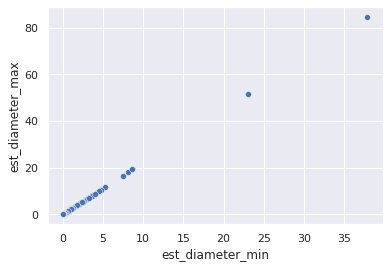

In [28]:
# Check distribution of diameter object
sns.scatterplot(x='est_diameter_min', y='est_diameter_max', data=df, palette=palette)

As we can see these 2 features that identified minimum and maximum has the same correlation between each others, so maybe we should to merge it with mean value.

In [29]:
df.head()

,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


### Velocity and Distance

In [30]:
duplicate_objects = df[df.duplicated(subset=['name'], keep=False)]['name'].value_counts().index.to_list()

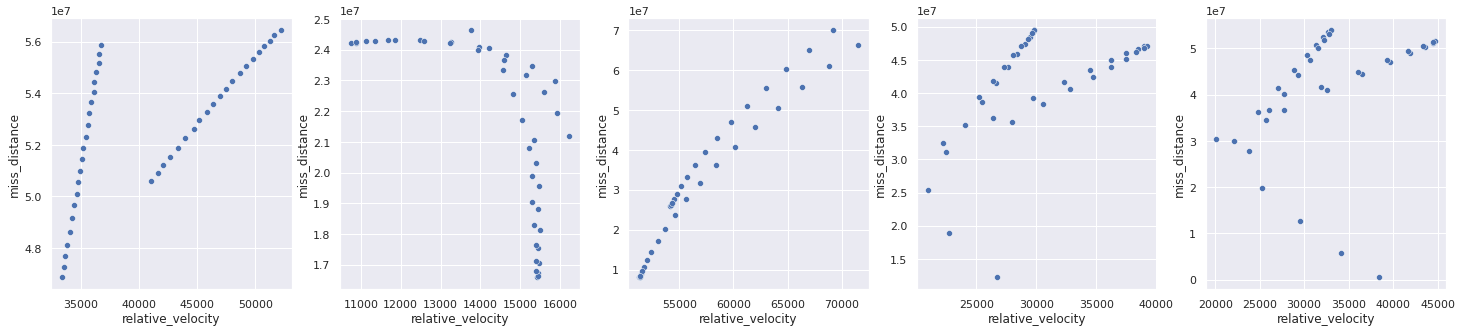

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
for i, object in enumerate(duplicate_objects[:5]):
    sns.scatterplot(
        data=df[df['name'] == object],
        x='relative_velocity',
        y='miss_distance',
        palette=palette,
        ax=axes[i],
    )

According to the laws of gravity, the velocity of an object is directly proportional to the distance between the object and the center of the universe.

Observing our data, we can see the relation between the velocity and the distance for some of the objects.

**Bivariate/Multivariate Analysis**

On this section, we will try to explore the relationship between the features and the target value, to explore some facts inside the dataset with **'hazardous'** label as our focus.

**Speed Object Analysis**

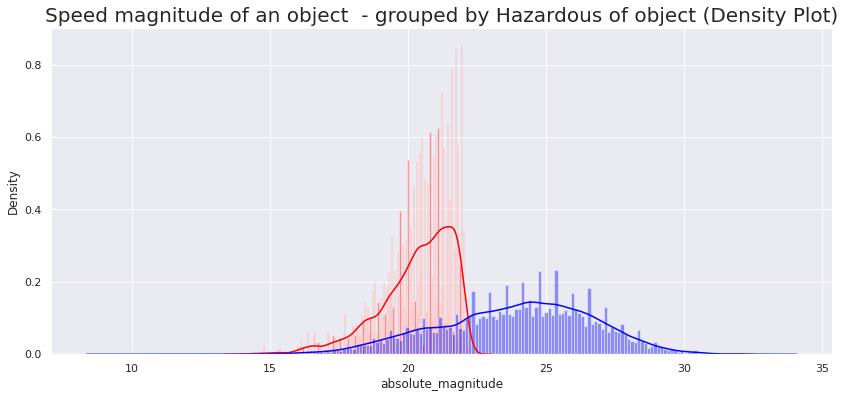

In [32]:
class_0 = df.loc[df['hazardous'] == False]["absolute_magnitude"]
class_1 = df.loc[df['hazardous'] == True]["absolute_magnitude"]
plt.figure(figsize = (14,6))
plt.title('Speed magnitude of an object  - grouped by Hazardous of object (Density Plot)', fontsize=20)
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="blue")
plt.show()

From graph above, as we can see an object that will be hazard for earth has highest density of 23 Absolute Magnitude. But for the other objects that are not hazardous, the absolute magnitude has disper distribution from 20 to 28.

**Missing distance analysis**

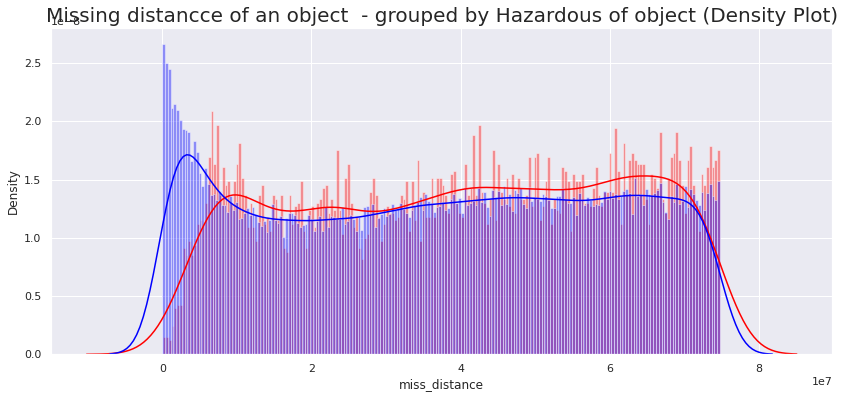

In [33]:
class_0 = df.loc[df['hazardous'] == False]["miss_distance"]
class_1 = df.loc[df['hazardous'] == True]["miss_distance"]
plt.figure(figsize = (14,6))
plt.title('Missing distancce of an object  - grouped by Hazardous of object (Density Plot)', fontsize=20)
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="blue")
plt.show()

From both of target label has the same result, but the difference between that 2 values on the shortes missing distance that will be likely not hazardous for an earth.

**Numerical Feature Selection**

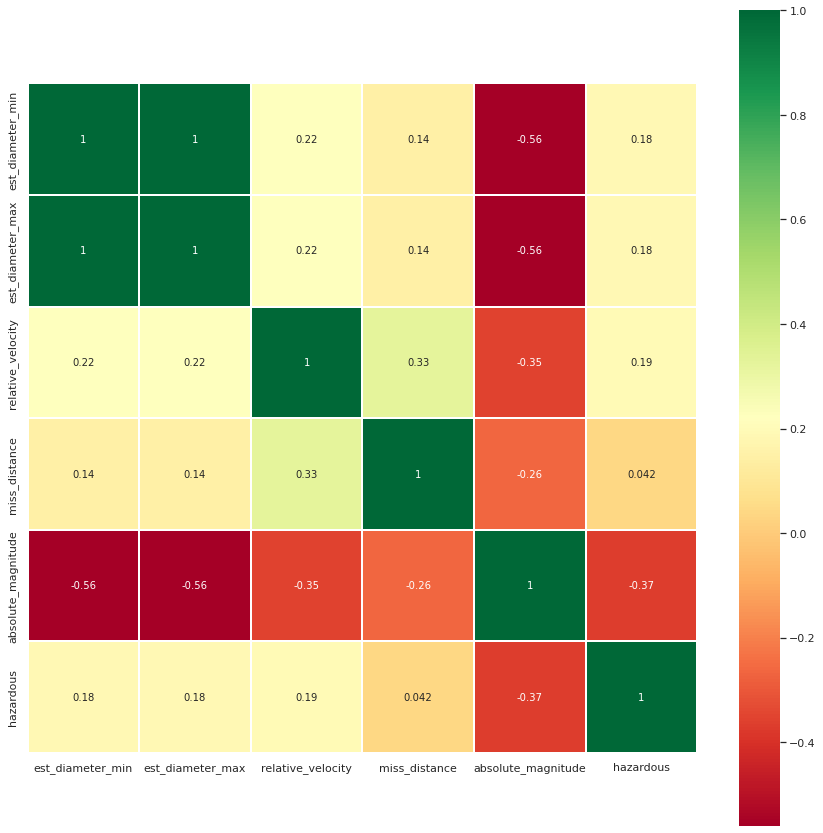

In [34]:
# Checking correlation between each variables

# Heatmap
corrmat= df.corr()
top_corr_feature = corrmat.index

plt.figure(figsize=(15,15))

g = sns.heatmap(df[top_corr_feature].corr(), annot=True, cmap = 'RdYlGn', square = 1, linewidths = 0.05)

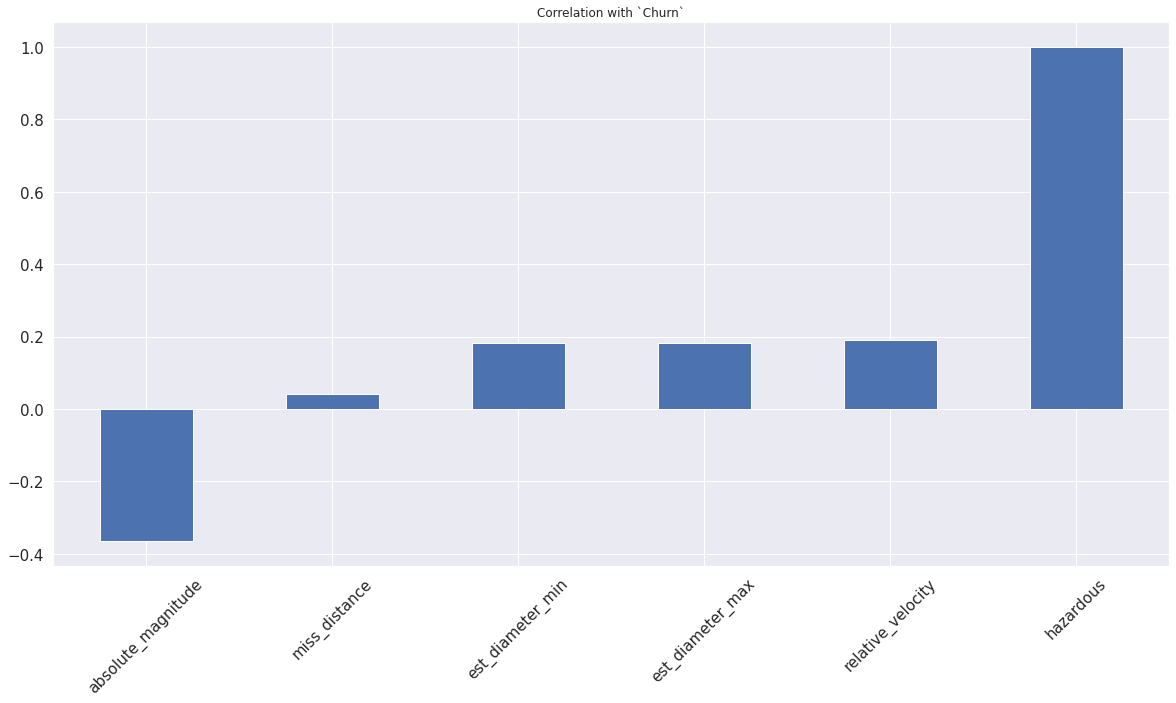

In [35]:
# Checking correlation between target variable and input variables

df.corrwith(df['hazardous']).sort_values().plot.bar(figsize=(20,10), title='Correlation with `Churn`', fontsize=15, rot=45, grid=True)
plt.show()

Based on graph above, we can summarize top features that correlate with **'hazardous'** as target label:

- absolute_magnitude has negative correlation with hazardous.
- est_diameter_min and est_diameter_max has positive correlation between the target value, but we need to manage this features to merge it and use mean value.

---

## Data Preprocessing

In this process I split my dataset into train, test, and inference dataset.



**Dataset Splitting**

In this process, I will split my dataset into different set:

- Use 80% from dataset for Train Set
- Use 20% from dataset for Test Set

all of those entries will be randomly selected from the dataset.

In [36]:
# Splitting Dataset

# X will be consist of features only
X = df.drop(['hazardous'], axis=1)

# y will be consist of target only
y = df['hazardous']

In [37]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42
)

In [38]:
X_train.head()

,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
35538,(2018 PR10),0.038420,0.085909,91103.489666,6.350550e+07,24.2
40393,277830 (2006 HR29),0.192555,0.430566,28359.611312,2.868167e+07,20.7
58540,(2013 HT25),0.004619,0.010329,107351.426865,5.388098e+04,28.8
61670,(2018 WR),0.015295,0.034201,21423.536884,5.103884e+07,26.2
11435,(2018 FU1),0.011603,0.025944,69856.053840,7.360836e+07,26.8


In [39]:
X_train.columns

Index(['name', 'est_diameter_min', 'est_diameter_max', 'relative_velocity',
       'miss_distance', 'absolute_magnitude'],
      dtype='object')

In [40]:
# categorizing features
num_cols = [
    'est_diameter_min', 'est_diameter_max', 'relative_velocity',
    'miss_distance', 'absolute_magnitude'
]

nom_cols = ['name']


### Handling Outliers

In [41]:
# check outlier summary only on numerical features
outlier_summary(X_train[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,est_diameter_min,42.721342,skewed,6621,9.111301
1,est_diameter_max,42.721342,skewed,6621,9.111301
2,relative_velocity,0.906590,skewed,1252,1.722904
3,miss_distance,-0.045471,normal,0,0.000000
4,absolute_magnitude,-0.131716,normal,83,0.114218


1. `Trimming`: if outliers' percentage < 5%
2. `Capping`: if outliers' percentage 5% - 15%
3. `None`: if outliers' percentage > 15%

In [42]:
# check outlier details
check_outlier(X_train[num_cols], 1.5)

,feats,upper_bound,lower_bound,tot_right_tail,tot_left_tail,tot_right_tail_pct,tot_left_tail_pct,tot_outlier,tot_outlier_pct
0,est_diameter_min,3.296215e-01,-1.669641e-01,6621,0,9.111301,0.000000,6621,9.111301
1,est_diameter_max,7.370562e-01,-3.733431e-01,6621,0,9.111301,0.000000,6621,9.111301
2,relative_velocity,1.143893e+05,-2.288003e+04,1252,0,1.722904,0.000000,1252,1.722904
3,miss_distance,1.041083e+08,-2.998751e+07,0,0,0.000000,0.000000,0,0.000000
4,absolute_magnitude,3.221436e+01,1.484773e+01,14,69,0.019266,0.094952,83,0.114218


In [43]:
# print X_train and y_train shape before trimming and capping
print('X_train shape before trimming and capping:', X_train.shape)
print('y_train shape before trimming and capping:', y_train.shape)

# trim and cap outliers
X_train, y_train = trim_cap_outliers(
    X_train,
    exception_list = nom_cols,
    fold=1.5,
    target=y_train
)

# print X_train and y_train shape after trimming and capping
print('X_train shape after trimming and capping:', X_train.shape)
print('y_train shape after trimming and capping:', y_train.shape)

X_train shape before trimming and capping: (72668, 6)
y_train shape before trimming and capping: (72668,)
X_train shape after trimming and capping: (71338, 6)
y_train shape after trimming and capping: (71338,)


### Handling Missing Values

In [44]:
# check missing values in train set
check_missing(X_train)

,feats,tot_missing,tot_missing_pct


In [45]:
# check missing values in train target
y_train.isna().sum()

0

In [46]:
# check missing values in test set
check_missing(X_test)

,feats,tot_missing,tot_missing_pct


In [47]:
# check missing values in test target
y_test.isna().sum()

0

### Feature Selection

In [48]:
# check outlier details
outlier_summary(X_train[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,est_diameter_min,1.229844,skewed,0,0.000000
1,est_diameter_max,1.229844,skewed,0,0.000000
2,relative_velocity,0.562587,skewed,187,0.262132
3,miss_distance,-0.030518,normal,0,0.000000
4,absolute_magnitude,-0.117334,normal,11,0.015420


In [49]:
X_train.columns

Index(['name', 'est_diameter_min', 'est_diameter_max', 'relative_velocity',
       'miss_distance', 'absolute_magnitude'],
      dtype='object')

In [50]:
# create list of numerical features with normal distribution
num_cols_norm = [
    'miss_distance', 'absolute_magnitude'
]

# create list of numerical features with skew
num_cols_skew = [
    'est_diameter_min', 'est_diameter_max', 'relative_velocity',
]

# # create final list of nominal features
# nom_cols = ['name']

In [93]:
# declare standard scaler
std_sc = StandardScaler()

# declare min max scaling
mm_sc = MinMaxScaler()

# declare one hot encoder
ohe_enc = OneHotEncoder(handle_unknown='ignore')

# declare ordinal encoder
ord_enc = OrdinalEncoder()

# declare label encoder
label_enc = LabelEncoder()

In [101]:
# create column transformer object using min max scaler
scale_mm = ColumnTransformer([
    ('num_norm', std_sc, num_cols_norm),
    ('num_skew', mm_sc, num_cols_skew),
    ('nom', 'passthrough', nom_cols),
])

# create column transformer object for use after oversampling
encode = ColumnTransformer([
    ('num', 'passthrough', slice(0, 5)),
    ('ord', ord_enc, [5]),
])

smote = SMOTE(random_state=42)

# create smotenc object
# categorical features will be put at the end, after the numerical ones
smotenc = SMOTENC(
    categorical_features= list(range(5, 6)),
    random_state=42
)

# # create pca object
# pca = PCA(n_components=0.8, random_state=42)


In [102]:
rf = RandomForestClassifier(random_state=42)

In [104]:
pipe_rf = Pipeline([
    ('scale', scale_mm),
    ('encode', encode),
    ('rf', rf),
])

In [105]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('scale',
                 ColumnTransformer(transformers=[('num_norm', StandardScaler(),
                                                  ['miss_distance',
                                                   'absolute_magnitude']),
                                                 ('num_skew', MinMaxScaler(),
                                                  ['est_diameter_min',
                                                   'est_diameter_max',
                                                   'relative_velocity']),
                                                 ('nom', 'passthrough',
                                                  ['name'])])),
                ('encode',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  slice(0, 5, None)),
                                                 ('ord', OrdinalEncoder(),
                                                  [5])])),
                ('rf', RandomForestClassifier(random_state=42))])

In [119]:
# calculate standard deviation of each feature
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [164]:
# create dataframe with features and their importance
importance_df = pd.DataFrame(
    dict(zip(
        num_cols_norm + num_cols_skew + nom_cols,
        rf.feature_importances_.tolist()
    )),
    index=['importance']
).transpose()

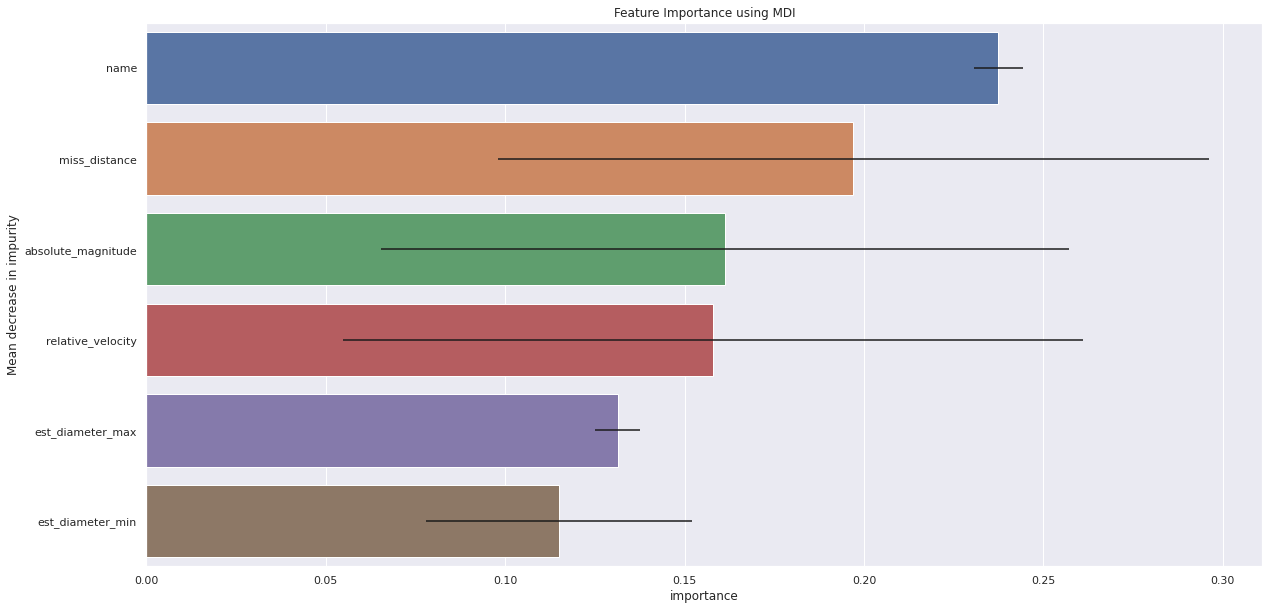

In [165]:
plt.figure(figsize=(20, 10))
sns.barplot(
    data=importance_df,
    x='importance',
    y=importance_df.index,
    xerr=std,
    order=importance_df['importance'].sort_values(ascending=False).index,
    orient='h'
)
plt.title('Feature Importance using MDI')
plt.ylabel('Mean decrease in impurity')
plt.show()